In [16]:
import firebase_admin
from firebase_admin import credentials, firestore

# Firebase 認証情報の読み込み
cred = credentials.Certificate("../firebase/serviceAccountKey.json")
firebase_admin.initialize_app(cred)

# Firestore クライアント
db = firestore.client()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [17]:
import random
def get_random_judges_data():
    # "Scripts" コレクションからデータを取得
    scripts_ref = db.collection("Judges")
    docs = list(scripts_ref.stream())
    random_docs = random.sample(docs, 1) if len(docs) >= 2 else docs
    scripts_data = [doc.to_dict() for doc in random_docs]
    print(scripts_data)  # 確認用
    return scripts_data

# ネタデータ取得
comedians = get_random_judges_data()
print(comedians[0]["criteria"])

[{'comedian_id': 'f927a8d291ef440aa584', 'criteria': '\u3000ストップウォッチを使用し、ネタのテンポや時間配分を厳密にチェック'}]
　ストップウォッチを使用し、ネタのテンポや時間配分を厳密にチェック


In [1]:
import getpass
import os
from langchain_google_vertexai import ChatVertexAI
import vertexai

vertexai.init(
        project="768904645084",
        location="us-central1"
    )
llm = ChatVertexAI(model_name= 'gemini-1.5-pro')

In [30]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser

judge_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "あなたは、お笑いコンテストの審査員です。"
            "与えられた漫才スクリプトに対して、評価コメントを作成してください。"
            "漫才のテーマは変えてはいけません。"
            "次の評価基準を踏まえて回答を生成してください。\n\n{criteria}",
        ),
        MessagesPlaceholder(variable_name="criteria"),
    ]
)

judge = judge_prompt | llm

In [31]:
manzai_script = ""
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "あなたは漫才師のネタ作成担当です。与えらた評価コメントを踏まえてネタを作成しなおします。"
            "漫才のテーマは変えてはいけません。"
            "元のネタは次の通りです。\n\n{manzai_script}",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | llm


In [55]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

#Agentに渡す状態を定義
class State(TypedDict):
    messages: Annotated[list, add_messages]
    manzai_script: str
    criteria: str
    iteration: int  # ループ回数を管理

#nodeとAgentを紐づけ
async def generation_node(state: State) -> State:
    return {
        "messages": state["messages"] + [HumanMessage(content=manzai_script)],  # 生成したスクリプトを追加
        "manzai_script": state["manzai_script"],
        "criteria": state["criteria"],
        "iteration": state["iteration"],
    }

async def judge_node(state: State) -> State:
    judge_prompt_partial = judge_prompt.partial(judge_data=state["criteria"])
    response = await (judge_prompt_partial | llm).ainvoke(state["messages"]) 
    
    return {
        "messages": state["messages"] + [response],  # 評価コメントを追加
        "manzai_script": state["manzai_script"],
        "criteria": state["criteria"],
        "iteration": state["iteration"],
    }

async def reflection_node(state: State) -> State:
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    manzai_script = state["manzai_script"]
    reflect_prompt_partial = reflection_prompt.partial(manzai_script=manzai_script)

    response = await (reflect_prompt_partial | llm).ainvoke(state["messages"])
    new_iteration = state["iteration"] + 1
    print(f"Reflection 完了。iteration {state['iteration']} -> {new_iteration}")
    return {
        "messages": state["messages"] + [response],  # 改良したスクリプトを追加
        "manzai_script": response.content,
        "criteria": state["criteria"],
        "iteration": new_iteration,  # ループ回数を更新
    }
#graphを構築
builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("judge", judge_node)
builder.add_node("reflect", reflection_node)
# **ノードの接続**
builder.add_edge(START, "generate")  # 最初に生成
builder.add_edge("generate", "judge")  # 生成後に審査
builder.add_edge("judge", "reflect")   # 審査後にリフレクション

MAX_ITERATIONS = 3  # 最大ループ回数

def should_continue(state: State):
    if state["iteration"] >= MAX_ITERATIONS:
        return END  
    return "generate" 

builder.add_conditional_edges("reflect", should_continue)

# **メモリの定義**
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

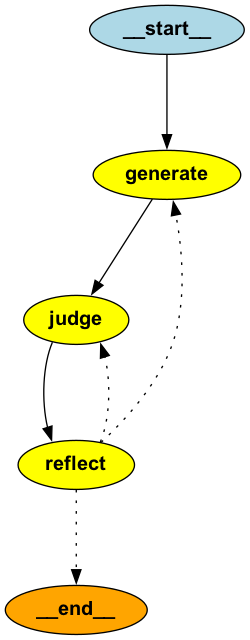

In [49]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [56]:
config = {"configurable": {"thread_id": "2"}}

async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content="審査員は与えられたmanzai_scriptを審査してコメントしてください。漫才師のネタ作り担当は審査コメントを元に修正してください。"
            )
        ],
        "manzai_script": '''
    タイムトラベル失敗というテーマで漫才をしてください。\n1. ツッコミ: 未来のコンビニって、どんな感じなんですかね？\n\n2. ボケ: レジ袋有料どころか、レジそのものが 有料！\n\n2. ツッコミ: レジ有料って、もはやコンビニちゃうやん！…他に未来のコンビニでありそうなことってありますか？\n\n3. ボケ: 店員さんが全員AIロボットで、しかもみんなタメ口！\n\n3.  ツッコミ: タメ口は別に未来感ないやろ！…未来のコンビニの商品はどんな感じなんですかね？\n\n4. ボケ: 賞味期限が西暦3000年とかで、もはや俺の寿命より長い！\n\n4. ツッコミ: \n5. ボケ: 食べ たら寿命も3000年まで伸びるって書いてあるけど、パッケージをよく見たら「当社比」って書いてある！\n\n5. ツッコミ: 4. 3000年って…それ、未来行けてへんやん！…タイムトラベルって難しいんです かね？\n\n6. ボケ: タイムトラベル、めっちゃ簡単っすよ！  昨日も江戸時代行ってきたんですけど、タイムマシンが人力車だったんで、足パンパンっす\n6. ツッコミ: 4. 3000年まで生きられるなら、当社比でもだいぶ伸びてるやん！…未来のコンビニの防犯対策はどうツッコミ: もうええわ。ありがとうございました。
    ''',  # ⬅ 初期の漫才スクリプト
        "criteria": str(comedians[0]["criteria"]),
        "iteration": 0,  # ⬅ 初期のループ回数を 0 に設定
    },
    config,
):
    print(event)
    print("---")


{'generate': {'messages': [HumanMessage(content='審査員は与えられたmanzai_scriptを審査してコメントしてください。漫才師のネタ作り担当は審査コメントを元に修正してください。', additional_kwargs={}, response_metadata={}, id='b9e9bd93-9312-477d-8d51-dc9ae8782a8e'), HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='600bfbc6-a939-4536-9eee-246b1079ee89')], 'manzai_script': '\n    タイムトラベル失敗というテーマで漫才をしてください。\n1. ツッコミ: 未来のコンビニって、どんな感じなんですかね？\n\n2. ボケ: レジ袋有料どころか、レジそのものが 有料！\n\n2. ツッコミ: レジ有料って、もはやコンビニちゃうやん！…他に未来のコンビニでありそうなことってありますか？\n\n3. ボケ: 店員さんが全員AIロボットで、しかもみんなタメ口！\n\n3.  ツッコミ: タメ口は別に未来感ないやろ！…未来のコンビニの商品はどんな感じなんですかね？\n\n4. ボケ: 賞味期限が西暦3000年とかで、もはや俺の寿命より長い！\n\n4. ツッコミ: \n5. ボケ: 食べ たら寿命も3000年まで伸びるって書いてあるけど、パッケージをよく見たら「当社比」って書いてある！\n\n5. ツッコミ: 4. 3000年って…それ、未来行けてへんやん！…タイムトラベルって難しいんです かね？\n\n6. ボケ: タイムトラベル、めっちゃ簡単っすよ！  昨日も江戸時代行ってきたんですけど、タイムマシンが人力車だったんで、足パンパンっす\n6. ツッコミ: 4. 3000年まで生きられるなら、当社比でもだいぶ伸びてるやん！…未来のコンビニの防犯対策はどうツッコミ: もうええわ。ありがとうございました。\n    ', 'criteria': '\u3000ストップウォッチを使用し、ネタのテンポや時間配分を厳密にチェック', 'iteration': 0}}
---
content

Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because it must include at least one parts field, which describes the prompt input. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because it must include at least one parts field, which describes the prompt input. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
Retrying langchain_google_vertexai.chat_models._acompletion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because it must include at least one parts field, which describes the prompt input. Learn more: https:/

InvalidArgument: 400 Unable to submit request because it must include at least one parts field, which describes the prompt input. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini